# PBL 2 - Residential Repower

- Original system operates for X years

- Need for roof repair, other reason to take panels off roof in year X

- Calculate financials (net present value, payback period) for reinstalling existing panels vs. repowering with new modules


In [ ]:
# !pip install -r https://raw.githubusercontent.com/PV-Tutorials/2025_PVPMC_PV_Repowering/main/requirements.txt

In [1]:
#Imports
import PySAM
import PV_ICE
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
from PySAM import Pvsamv1 as pv
from PySAM import Pvwattsv8 as pvwatts
from PySAM import Cashloan as res
from PySAM import Grid as grid
from PySAM import Utilityrate5 as ur
import PySAM.Pvsamv1Tools as pvtools
import PySAM.ResourceTools as tools


In [2]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("PySAM version ", PySAM.__version__)
print("PV_ICE version ", PV_ICE.__version__)

Working on a  Windows 10
Python version  3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.1.4
PySAM version  7.0.0
PV_ICE version  0.4.4.dev2+g378a012.d20250320


## 1. METRICS


Roof replacement year (years from system install), or year where decision is needed to be made between reinstall vs repower

In [3]:
decision_year = 10 #years

remaining_years = np.arange(1, 20, 1)
reinstall_npv = []
reinstall_payback = []


NameError: name 'np' is not defined

## 2. Setup Base Case for Residential Repowering Scenario


### Load SAM system

In [4]:
#Read in PySAM json
# create a new instance of the Pvwattsv8 module
pv_model = pv.default("FlatPlatePVResidential")
fin_model = res.from_existing(pv_model)
#Alternatively, use PVWatts
#pv_model = PySAM.Pvwattsv8.new()
grid_model = res.from_existing(pv_model)
ur_model = ur.from_existing(pv_model)

#User: input json files from SAM
# json_file_folder = "Repower_example"
# json_files = next(os.walk(json_file_folder))[2]
# json_files.sort()
# get the inputs from the JSON file
for json_file in os.listdir('PBL 2_Data'):
    with open( 'PBL 2_Data/' + json_file, 'r') as f:
            pv_inputs = json.load( f )
    
    # iterate through the input key-value pairs and set the module inputs
    for k, v in pv_inputs.items():
        if k != 'number_inputs':
            try:
                pv_model.value(k, v)
            except:
                try:
                    ur_model.value(k, v)
                except:
                    try:
                        grid_model.value(k, v)
                    except:
                        try:
                            fin_model.value(k, v)
                        except:
                            print("Variable not found in modules:" + str(k))

fin_model = res.from_existing(pv_model)
#Alternatively, use PVWatts
#pv_model = PySAM.Pvwattsv8.new()
grid_model = res.from_existing(pv_model)
ur_model = ur.from_existing(pv_model)


NameError: name 'pv' is not defined

### Download resource data

In [4]:
#Read in weather data from SAM, or use NSRDB downloads in SAM format, or use dictionary of solar data
#A. You already have a file
weather_file = "data/CO_weather_data.csv"
pv_model.SolarResource.solar_resource_file = weather_file


Starting data download for solar using 1 thread workers.
Getting list of available NSRDB files for 39.75, -105.22.
Error for 39.75, -105.22: {
  "error": {
    "code": "API_KEY_INVALID",
    "message": "An invalid api_key was supplied. Get one at https://developer.nrel.gov/signup/"
  }
}


### Set module degradation from initial install to decision point


In [ ]:
degradation_rate = pv_model.Lifetime.dc_degradation #sequence, variable length depending on SAM input, if flat rate then length=1
degradation_todate = 0 #initialize
if len(degradation_rate) > 1:
    degradation_todate = degradation_rate[-1] #Use last element in array for most recent year, degradation rates are not cumulative
else:
    degradation_todate = degradation_rate[0] * decision_year #Only 1 value

print(degradation_todate)

## 2. Set Reinstall Cases with varying remaining years of life



In [6]:
reinstall = pv.from_existing(pv_model)
reinstall_financial = res.from_existing(fin_model)
grid_model = grid.from_existing(reinstall_financial)
ur_model = ur.from_existing(reinstall_financial)
repower = pv.from_existing(pv_model)
repower_financial = res.from_existing(fin_model)


reinstall.Losses.subarray1_nameplate_loss = degradation_todate #Set degradation calculation as a nameplate decrease in reinstalled module's power output
reinstall_system_capacity = reinstall.SystemDesign.system_capacity * 1000 #Wdc
reinstall_variable_cost = 0.43 #$/Wdc
reinstall_fixed_cost = 2400 #$
reinstall_financial.SystemCosts.total_installed_cost = reinstall_variable_cost * reinstall_system_capacity
#reinstall_financial.SystemCosts.total_installed_cost = reinstall_fixed_cost

# Doing a sampling for varying remaining years of life between 1 and 20 years for the original system.
for lifetime in remaining_years:
    reinstall.Lifetime.analysis_period = lifetime
    grid_model.Lifetime.analysis_period = lifetime
    ur_model.Lifetime.analysis_period = lifetime
    
    
    reinstall.execute()
    grid_model.execute()
    ur_model.execute()
    reinstall_financial.FinancialParameters.analysis_period = lifetime
    # reinstall_financial.SystemOutput.degradation = [0]
    reinstall_financial.SystemOutput.gen = reinstall.Outputs.gen
    reinstall_financial.execute()
    reinstall_npv.append(reinstall_financial.Outputs.npv) #$
    reinstall_payback.append(reinstall_financial.Outputs.payback) #years

print(reinstall_npv)
print(reinstall_payback)


[-1392.3612214199188, -440.82184052536763, 448.76937280818765, 1280.444242014326, 2057.9722556276574, 2784.669127474299, 3463.7302703639925, 4098.2755026602645, 4691.220479513297, 5245.290043694784, 5763.0307039638665, 6246.82229794477, 6698.888892777398, 7121.308973325625, 7516.024964478006, 7884.852131037956, 8229.48689586077, 8551.514614240616, 8852.416840069367]
[nan, nan, nan, 2.145915907149698, 2.145915907149698, 2.145915907149698, 2.145915907149698, 2.145915907149698, 2.145915907149698, 2.145915907149698, 2.145915907149698, 2.145915907149698, 2.145915907149698, 2.145915907149698, 2.145915907149698, 2.145915907149698, 2.145915907149698, 2.145915907149698, 2.145915907149698]


## 3. Calculation Mode: Known new system capacity, unknown remaining lifetime for existing system

In [7]:
#Repower case - Known system size, lifetime
grid_model = grid.from_existing(repower_financial)
ur_model = ur.from_existing(repower_financial)

capacity_min = 5 #kW
capacity_max = 10 #kW

new_system_analysis_period = 30 #years
repower.Lifetime.analysis_period = new_system_analysis_period
grid_model.Lifetime.analysis_period = new_system_analysis_period
ur_model.Lifetime.analysis_period = new_system_analysis_period

new_system_capacity = 8 #kWDC
repower_cost_per_wdc = 2.76 #$/Wdc
repower_cost_flat = 10000 #$
repower_npv = 0
repower_payback = 0
#Select new module?
mod_dict = PySAM.Pvsamv1Tools.set_cec_module_library_selection(repower, "Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R")
print(mod_dict)

n_strings, n_combiners, n_inverters, calculated_system_capacity = pvtools.size_electrical_parameters(repower, new_system_capacity, 1.06)

repower.execute()
grid_model.execute()
ur_model.execute()
repower_financial.SystemOutput.gen = repower.Outputs.gen
repower_financial.SystemCosts.total_installed_cost = repower_cost_per_wdc * repower.SystemDesign.system_capacity * 1000
#ITC 30%
repower_financial.TaxCreditIncentives.itc_fed_percent = [30]
# repower_financial.SystemCosts.total_installed_cost = repower_cost_flat

repower_financial.execute()
repower_npv = repower_financial.Outputs.npv
repower_payback = repower_financial.Outputs.payback
    

This function does not set the bifaciality of a module based on the bifacial based on the lib_is_bifacial value. Please change cec_is_bifacial to 1 to make the module bifacial.
{'lib_manufacturer': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 'Maxeon Solar Technologies Ltd.'}, 'cec_material': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 'Mono-c-Si'}, 'lib_is_bifacial': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 0}, 'Unnamed: 4': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 400.359}, 'Unnamed: 5': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 377.7}, 'cec_area': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 1.9}, 'lib_length': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': nan}, 'lib_width': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': nan}, 'cec_n_s': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 112}, 'cec_i_sc_ref': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 13.06}, 'cec_v_oc_ref': {'Maxeon Solar

C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

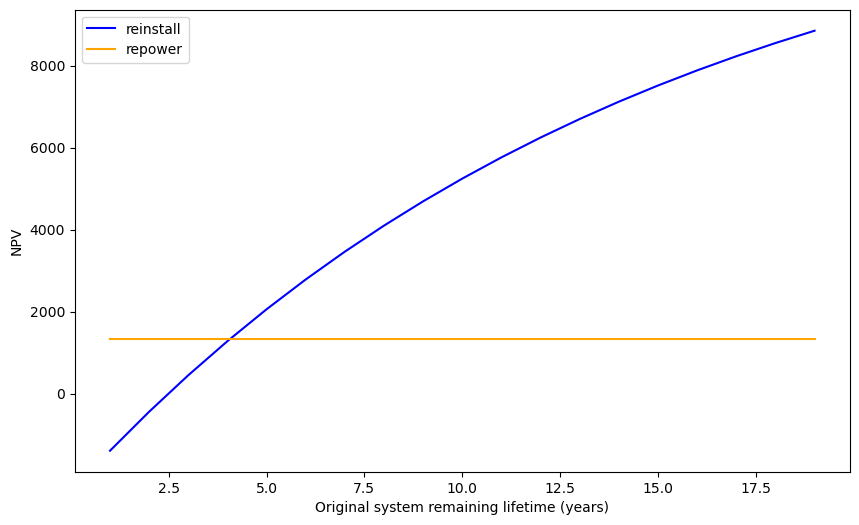

In [8]:
# Sample data
data = pd.DataFrame({
    'x1': remaining_years,
    'y1': reinstall_npv,
    
})

data['y2'] = repower_npv

# Create the main plot
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(x='x1', y='y1', data=data, ax=ax1, color='blue', label='reinstall')
ax1.set_xlabel('Original system remaining lifetime (years)')
ax1.set_ylabel('NPV')

# Create the second x-axis
sns.lineplot(x='x1', y='y2', data=data, ax=ax1, color='orange', label='repower')
#ax2.set_xbound(ax1.get_xbound())
#plt.legend(['reinstall', 'repower'])

# Display the plot
plt.show()

## 4. Calculation Mode: Evaluating ideal new system capacity, if you know remaining lifetime for existing system

In [14]:
#Repower case
grid_model = grid.from_existing(repower_financial)
ur_model = ur.from_existing(repower_financial)

capacity_min = 5 #kW
capacity_max = 10 #kW

new_system_analysis_period = 30 #years
repower.Lifetime.analysis_period = new_system_analysis_period
grid_model.Lifetime.analysis_period = new_system_analysis_period
ur_model.Lifetime.analysis_period = new_system_analysis_period

capacity_range = np.arange(6,10,0.5)
repower_cost_per_wdc = 0.80 #$/Wdc
repower_cost_flat = 10000 #$
repower_npv = []
repower_payback = []
#Select new module?
mod_dict = PySAM.Pvsamv1Tools.set_cec_module_library_selection(repower, "Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R")
print(mod_dict)
for sys_cap in capacity_range:
    n_strings, n_combiners, n_inverters, calculated_system_capacity = pvtools.size_electrical_parameters(repower, sys_cap, 1.06)
    
    repower.execute()
    grid_model.execute()
    ur_model.execute()
    repower_financial.SystemOutput.gen = reinstall.Outputs.gen
    repower_financial.SystemCosts.total_installed_cost = repower_cost_per_wdc * repower.SystemDesign.system_capacity * 1000
    repower_financial.TaxCreditIncentives.itc_fed_percent = [30]
    # repower_financial.SystemCosts.total_installed_cost = repower_cost_flat

    repower_financial.execute()
    repower_npv.append(repower_financial.Outputs.npv)
    repower_payback.append(repower_financial.Outputs.payback)
    

This function does not set the bifaciality of a module based on the bifacial based on the lib_is_bifacial value. Please change cec_is_bifacial to 1 to make the module bifacial.
{'lib_manufacturer': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 'Maxeon Solar Technologies Ltd.'}, 'cec_material': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 'Mono-c-Si'}, 'lib_is_bifacial': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 0}, 'Unnamed: 4': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 400.359}, 'Unnamed: 5': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 377.7}, 'cec_area': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 1.9}, 'lib_length': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': nan}, 'lib_width': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': nan}, 'cec_n_s': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 112}, 'cec_i_sc_ref': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 13.06}, 'cec_v_oc_ref': {'Maxeon Solar

In [10]:
#Reinstall case - Known number of remaining years of life
reinstall = pv.from_existing(pv_model)
reinstall_financial = res.from_existing(fin_model)
grid_model = grid.from_existing(reinstall_financial)
ur_model = ur.from_existing(reinstall_financial)
repower = pv.from_existing(pv_model)
repower_financial = res.from_existing(fin_model)

lifetime = 19 #years, user input for years of remaining life
reinstall_npv = 0
reinstall_payback = 0
reinstall.Losses.subarray1_nameplate_loss = degradation_todate
reinstall_system_capacity = reinstall.SystemDesign.system_capacity * 1000 #Wdc
reinstall_variable_cost = 0.30 #$/Wdc
reinstall_fixed_cost = 2400 #$
reinstall_financial.SystemCosts.total_installed_cost = reinstall_variable_cost * reinstall_system_capacity
#reinstall_financial.SystemCosts.total_installed_cost = reinstall_fixed_cost

reinstall.Lifetime.analysis_period = lifetime
grid_model.Lifetime.analysis_period = lifetime
ur_model.Lifetime.analysis_period = lifetime


reinstall.execute()
grid_model.execute()
ur_model.execute()
reinstall_financial.FinancialParameters.analysis_period = lifetime
reinstall_financial.SystemOutput.degradation = [0]
reinstall_financial.SystemOutput.gen = reinstall.Outputs.gen
reinstall_financial.execute()
reinstall_npv = reinstall_financial.Outputs.npv #$
reinstall_payback = reinstall_financial.Outputs.payback #years

print(reinstall_npv)
print(reinstall_payback)


12521.406041979779
1.4304512013706265


C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

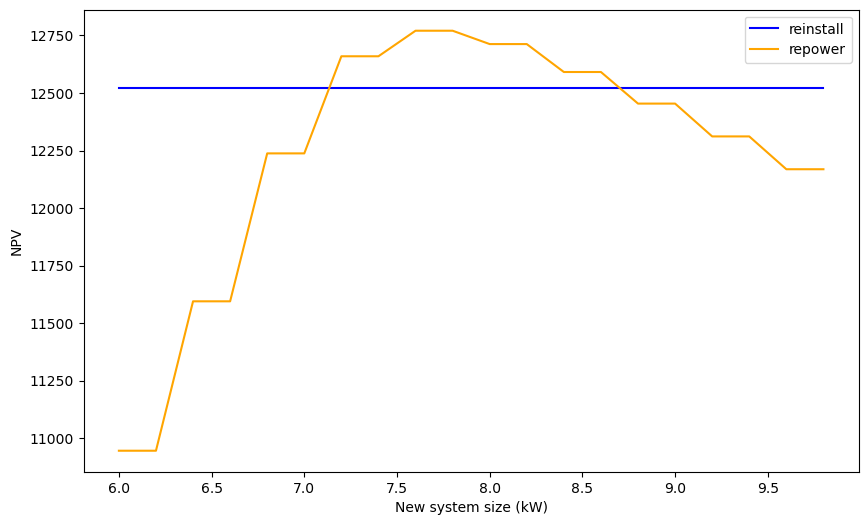

In [11]:
# Sample data
data = pd.DataFrame({
    'x1': capacity_range,
    'y1': repower_npv,
    
})

data['y2'] = reinstall_npv

# Create the main plot
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(x='x1', y='y2', data=data, ax=ax1, color='blue', label='reinstall')
ax1.set_xlabel('New system size (kW)')
ax1.set_ylabel('NPV')

# Create the second x-axis
sns.lineplot(x='x1', y='y1', data=data, ax=ax1, color='orange', label='repower')
#ax2.set_xbound(ax1.get_xbound())
#plt.legend(['repower', 'reinstall'])

# Display the plot
plt.show()